In [10]:
%pip install -q -U langchain
%pip install -q -U langchain-google-genai

In [11]:
from google.colab import userdata
google_api_key = userdata.get('GEMINI_API_KEY')

In [13]:
from langchain_google_genai import ChatGoogleGenerativeAI

# Initialize an instance of the ChatGoogleGenerativeAI with specific parameters
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",  # Specify the model to use
    api_key=google_api_key,     # Provide the Google API key for authentication
)

In [14]:
!pip install langgraph

In [15]:
from langchain_core.messages.ai import AIMessage

from typing import TypedDict, List
from langgraph.graph import StateGraph,START, END
from langchain.prompts import PromptTemplate
from langgraph.graph.state import CompiledStateGraph
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image



In [16]:
ai_msg: AIMessage = llm.invoke("Hi?")

In [17]:
print(ai_msg.content)
print(type(ai_msg.content))

Hi! How can I help you today? 

<class 'str'>


In [18]:
from typing_extensions import TypedDict

# class FirstLLMAgentCall(TypedDict):
#     prompt: str
#     output: str
class State(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str

In [19]:
from langchain_google_genai import ChatGoogleGenerativeAI
# from langchain.prompts import PromptTemplate
# from langchain_core.messages.human import HumanMessage
# from langchain_core.messages.ai import AIMessage


def classification_node(state: State):
    ''' Classify the text into one of the categories: News, Blog, Research, or Other '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Classify the following text into one of the categories: News, Blog, Research, or Other.\n\nText:{text}\n\nCategory:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))

    # # Get the response from the model
    # response_text = llm(message.content)

    # # Create an AIMessage from the response
    # classification = AIMessage(content=response_text).content.strip()

    # return {"classification": classification}
    classification = llm.invoke([message]).content.strip(",  ")
    return {"classification": classification}

def entity_extraction_node(state: State):
    ''' Extract all the entities (Person, Organization, Location) from the text '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Extract all the entities (Person, Organization, Location) from the following text. Provide the result as a comma-separated list.\n\nText:{text}\n\nEntities:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))

    # # Get the response from the model
    # response_text = llm(message.content)

    # # Create an AIMessage from the response and split the entities
    # entities = AIMessage(content=response_text).content.strip().split(", ")

    # return {"entities": entities}
    entities = llm.invoke([message]).content.strip().split(", ")
    return {"entities": entities}

def summarization_node(state: State):
    ''' Summarize the text in one short sentence '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Summarize the following text in one short sentence.\n\nText:{text}\n\nSummary:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))

    # # Get the response from the model
    # response_text = llm(message.content)

    # # Create an AIMessage from the response
    # summary = AIMessage(content=response_text).content.strip()

    # return {"summary": summary}
    summary = llm.invoke([message]).content.strip()
    return {"summary": summary}
    # def node_1(state: FirstLLMAgentCall):
    # print("---Node 1---", state)
    # prompt = state["prompt"]
    # ai_msg: AIMessage = llm.invoke(prompt)
    # return {"output": ai_msg.content}


In [20]:
!pip install langgraph


In [21]:

workflow = StateGraph(State)

# Add nodes to the graph
workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction", entity_extraction_node)
workflow.add_node("summarization", summarization_node)

# Add edges to the graph
workflow.set_entry_point("classification_node") # Set the entry point of the graph
workflow.add_edge("classification_node", "entity_extraction")
workflow.add_edge("entity_extraction", "summarization")
workflow.add_edge("summarization", END)


In [22]:
from IPython.display import Image, display # Preview Graph

from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph # type

# Build graph
builder: StateGraph = StateGraph(state_schema=State)

In [23]:
print(type(builder))

<class 'langgraph.graph.state.StateGraph'>


In [24]:
# Add
graph: CompiledStateGraph = workflow.compile()

In [25]:
print(graph)

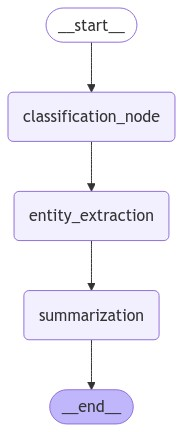

In [26]:
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
sample_text = """
Artificial general intelligence (AGI) is defined as the intelligence of machines that allows them to comprehend,
learn, and perform intellectual tasks much like humans. AGI emulates the human mind and behavior to solve any kind
of complex problem.
"""

# Simulating the state input for testing
state_input = {"text": sample_text}

# Run the nodes
classification_result = classification_node(state_input)
entity_extraction_result = entity_extraction_node(state_input)
summarization_result = summarization_node(state_input)

# Print results
print("Classification:", classification_result["classification"])
print("\nEntities:", entity_extraction_result["entities"])
print("\nSummary:", summarization_result["summary"])


Classification: The category is **Other**. 

While the text discusses a topic related to technology and research (Artificial General Intelligence), it doesn't fit neatly into any of the given categories:

* **News:** It lacks the elements of a news story, such as a specific event, timeliness, or reporting on a current event.
* **Blog:**  It doesn't have a personal voice, conversational tone, or aim to engage readers with opinions or experiences.
* **Research:** It's too brief and lacks the depth, methodology, analysis, or citations typical of research. 

The text is more like a simple **definition** or **explanation** of AGI. 


Entities: ['There are no named entities (Person', 'Organization', 'Location) in the provided text.']

Summary: Artificial general intelligence (AGI) aims to create machines that can think and learn like humans, enabling them to solve any complex problem.
